<a href="https://colab.research.google.com/github/kozihika/nlp100/blob/main/CH07_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#第7章: 機械学習

1. **データ取得・確認（60）**
   　データを読み、ラベル分布を確認する

2. **特徴量設計（ベクトル化）（61）**
   　テキスト → Bag of Words → 数値ベクトル

3. **モデル学習（62）**
   　ロジスティック回帰を学習

4. **単一予測の確認（63）**
   　まず1件、ちゃんと予測できるかを見る

5. **確率出力の理解（64）**
   　条件付き確率としての出力を確認

6. **推論用関数の実装（65）**
   　任意テキストに対して予測できる形にする

7. **誤りの内訳を見る（66）**
   　混同行列

8. **指標で性能評価（67）**
   　accuracy / precision / recall / F1

9. **モデルの中身を見る（68）**
   　係数（単語の寄与）を確認

10. **ハイパーパラメータ調整（69）**
    　正則化パラメータ C を変えて最適化


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# sepで区切り文字を指定する（csvなら不要）
import pandas as pd

train_df = pd.read_csv(
    "/content/drive/MyDrive/nlp100/ch07/SST-2/train.tsv",
    sep="\t"
)
dev_df = pd.read_csv(
    "/content/drive/MyDrive/nlp100/ch07/SST-2/dev.tsv",
    sep="\t"
)

### 60. データの入手・整形

GLUEのウェブサイトからSST-2データセットを取得せよ。学習データ（train.tsv）と検証データ（dev.tsv）のそれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [ ]:
# dfでもseでも利用可能。value_counts= 種類ごとの数, sort_values= 昇順での並べ替え, unique=　種類を調べる。
print(train_df['label'].value_counts(), dev_df['label'].value_counts())
print(train_df['label'].unique())

### 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（train.tsv）および検証データ（dev.tsv）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、「too loud , too goofy」というテキストに対応する特徴ベクトルは、以下のような記号オブジェクトで表現される。

```
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した記号オブジェクトでまとめておく。例えば、先ほどの「too loud , too goofy」に対してラベル「0」（ネガティブ）が付予された事例は、以下のオブジェクトで表現される。

```
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような記号オブジェクトに変換したうえで、学習データと検証データのそれぞれを、記号オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [ ]:
#dfを1行ずつ取り出して、行ごとに、列の特徴量をキーとバリューとして{'text','label','feature'} の辞書にまとめ、リストに追加する。
from collections import Counter

def get_feature_vector(text):
    return dict(Counter(text.split()))

def create_dataset(df):
    data = []
    for _, row in df.iterrows(): #iterrowsで(index, 行データ) を1行ずつ返すイテレータ
        item = {
            'text': row['sentence'],
            'label': str(row['label']),
            'feature': get_feature_vector(row['sentence'])
        }
        data.append(item)
    return data

# Create datasets
train_data = create_dataset(train_df)
dev_data = create_dataset(dev_df)

# Display the first instance of training data
print(train_data[:10])

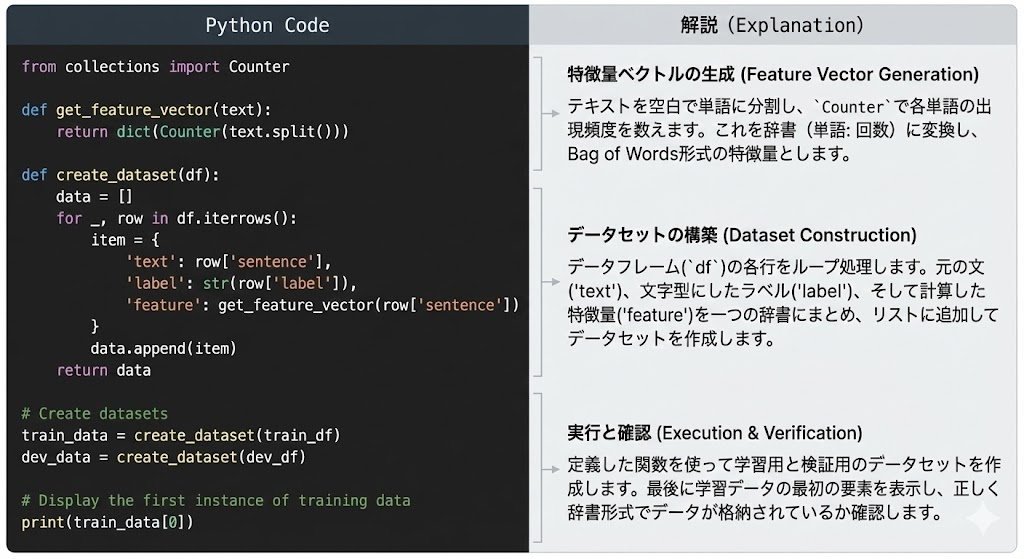

### 62. 学習  

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [ ]:
'''
   featは下記のスタイルを想定している
[
  {'the': 2, 'movie': 1, 'worst': 1},
  {'great': 1, 'film': 1}
]
'''

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Convert feature dictionaries to vectors
vectorizer = DictVectorizer()
#fitで訓練データの全ての単語（特徴量）を登録して、transformで該当の単語の頻度をまとめる
X_train = vectorizer.fit_transform([d['feature'] for d in train_data])  #二重リストっぽい、行列
y_train = [d['label'] for d in train_data]

# Train Logistic Regression model
# increased max_iter to ensure convergence
model = LogisticRegression(max_iter=1000, random_state=42)  #iterは、重み更新を行う回数。最大1000回行うが、収束したら止まる。
model.fit(X_train, y_train)

### 63. 予測

62で学習したロジスティック回帰モデルを用いて、検証データの最初の事例のラベルを予測せよ。実際のラベルと予測結果を確認せよ。

In [ ]:
# 予測する時のベクトル化は、fitをしたら検証データだけでまた語彙を作ってしまうので、transformだけ使う
X_dev = vectorizer.transform([d['feature'] for d in dev_data])
y_dev = [d['label'] for d in dev_data]

print(model.predict(X_dev[0]))
model.score(X_dev, y_dev)

NameError: name 'vectorizer' is not defined

### 64. 条件付き確率

62で学習したロジスティック回帰モデルを用いて，検証データの最初の事例に対する各ラベルの条件付き確率を求めよ。

In [ ]:
# ロジスティック回帰は、本質的に「条件付き確率 𝑃(𝑦∣𝑥) をモデル化するモデル」なので、常に条件付き確率ー
proba = model.predict_proba(X_dev[0])

print(model.predict(X_dev[0]))
print("P(y=0 | x) =", proba[0][0])
print("P(y=1 | x) =", proba[0][1])
print("sum =", proba[0][0] + proba[0][1])


### 65. テキストのポジネガの予測

62で学習したロジスティック回帰モデルを利用し，任意の文字列に対してポジティブ（1）かネガティブ（0）かを予測するプログラムを実装せよ。例えば「the worst movie I've ever seen」の感情を予測してみよ。

In [ ]:
#今回は、テキスト→Bag of words→ベクトル→予測で関数にする。

'''
   featは下記のスタイルを想定している
[
  {'the': 2, 'movie': 1, 'worst': 1},
  {'great': 1, 'film': 1}
]
'''

def predict_sentiment(text):
  feat = dict(Counter(text.split()))
  x = vectorizer.transform([feat])
  return model.predict(x)

print(predict_sentiment("the first movie I've ever seen"))

### 66. 混同行列の作成

検証データに対する予測結果と正解ラベルから混同行列を作成せよ。

In [ ]:
#混同行列とは、予測ラベルと正解ラベルで正解と誤りの件数を表にしたもの

from sklearn.metrics import confusion_matrix

# 予測（dev全体）
y_pred = model.predict(X_dev)

# 混同行列（行=正解, 列=予測）、予測と実際があればいい
cm = confusion_matrix(y_dev, y_pred, labels=['0', '1'])
print(cm)


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_dev)
cm = confusion_matrix(y_dev, y_pred, labels=['0','1'])

cm_df = pd.DataFrame(cm, index=['true_0','true_1'], columns=['pred_0','pred_1'])
cm_df


### 67. 精度の評価

学習データおよび検証データを対象に，正解率（accuracy），適合率（precision），再現率（recall），F1スコアを算出せよ。

In [ ]:
#適合率、再現率は、1(ポジティブ)に対してだけ求めている
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- train側の予測 ---
y_train_pred = model.predict(X_train)

# --- dev側の予測 ---
y_dev_pred = model.predict(X_dev)

def show_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, pos_label='1')
    rec = recall_score(y_true, y_pred, pos_label='1')
    f1  = f1_score(y_true, y_pred, pos_label='1')
    print(f"[{name}] accuracy={acc:.4f} precision={pre:.4f} recall={rec:.4f} f1={f1:.4f}")

show_metrics("train", y_train, y_train_pred)
show_metrics("dev",   y_dev,   y_dev_pred)


###68. 特徴量の重みの確認
学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。



In [ ]:
#モデルのxの係数を取りだして、ランキングを作りそのインデックスを取り出す。
#係数の順番と単語は対応しているので、インデックスで対応する係数と単語を取ってくる。

#単語の数だけ説明変数があり、それぞれの単語に係数がついている

import numpy as np

# 特徴量名（列名）と係数を取り出す
feature_names = vectorizer.get_feature_names_out()   # shape: (n_features,)
coefs = model.coef_[0]                               # shape: (n_features,)
print(coefs)
# 係数の大きい順 / 小さい順のインデックス
# 係数とそのリストのidxが一致する（argsortはidxを返す）
top_idx = np.argsort(coefs)[-20:][::-1]   # 大きい方20（降順）
bottom_idx = np.argsort(coefs)[:20]       # 小さい方20（昇順）

print("=== Top 20 positive features (push toward label=1) ===")
for i in top_idx:
    print(f"{feature_names[i]:<20} {coefs[i]: .4f}")

print("\n=== Top 20 negative features (push toward label=0) ===")
for i in bottom_idx:
    print(f"{feature_names[i]:<20} {coefs[i]: .4f}")


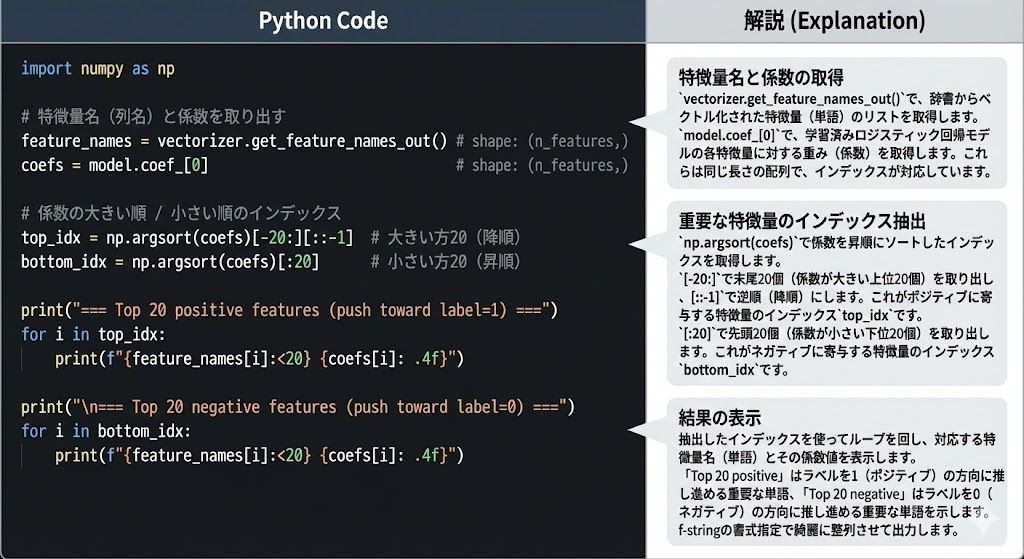

###69. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

In [ ]:
#正則化の点の数だけループさせて、毎回モデルを学習させて訓練データと検証データバージョンで評価して結果を保存する

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# C を対数スケールで動かす（小さい=強い正則化、大きい=弱い正則化）
C_list = np.logspace(-4, 4, 17)  # 1e-4 〜 1e4 を17点

dev_acc_list = []
train_acc_list = []

for C in C_list:
    clf = LogisticRegression(
        C=C,
        max_iter=1000,
        random_state=42,
        solver="lbfgs"   # デフォルト（L2正則化）
    )
    clf.fit(X_train, y_train)

    # train / dev の accuracy
    y_train_pred = clf.predict(X_train)
    y_dev_pred   = clf.predict(X_dev)

    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    dev_acc_list.append(accuracy_score(y_dev, y_dev_pred))

# グラフ化
plt.figure()
plt.semilogx(C_list, train_acc_list, marker="o", label="train")
plt.semilogx(C_list, dev_acc_list, marker="o", label="dev")
plt.xlabel("C (inverse of regularization strength)")
plt.ylabel("Accuracy")
plt.title("Effect of Regularization (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()


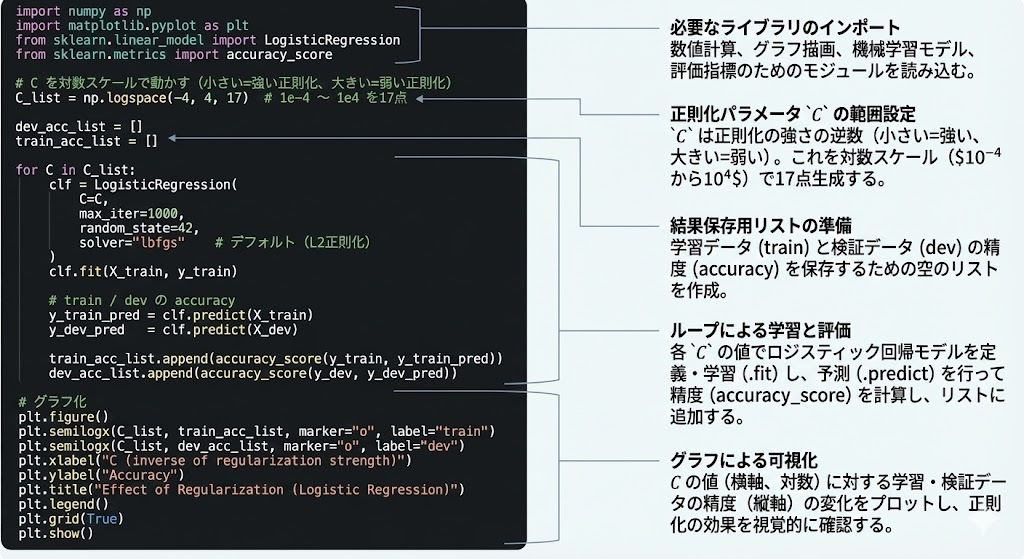